# Applied Data Science by IBM
## Capstone project

Moscow and New York are two big cities that "never sleep". Both cities have milions of people, have lots of things to do and places to go to. At the same time, being found in 1147, Moscow has longer history, and New York city is highly enreached with culture brough by immigrants of various nationalities.

Can we use data science tools to determine, if there are similar districts in Moscow and New York? How many unique districts are there in each city?

In this project, we are going to explore, segment and compare the neighborhoods of Moscow and New York.
To do this, we are going to make a table of districts for each city, explore venues in each district using FoursquareAPI, then perform clustering using Scikit-learn library and visualize the clusters using Folium

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Install beautifulsoup
#!pip install beautifulsoup4
from bs4 import BeautifulSoup

#Import libraries for Foursquare API
from urllib.request import urlopen
import requests 
from pandas.io.json import json_normalize
import json

#Install geocode for getting coordinates
!pip install geopy
from geopy.geocoders import Nominatim

#Install sci kit learn for machine learning
from sklearn.cluster import KMeans

!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 8.0 MB/s  eta 0:00:01


### Scraping

We do not have a table of Moscow districts with geocoordinates. To make such a table, we are going to scrape Moscow districts list from Wikipedia page using BeautifulSoup. Then we will add geocoordinates using geopy

In [3]:
#get Moscow neighborhood data on Wikipedia
url = 'https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow'
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [4]:
#get a table containing all districts of Moscow
table_content = []
for table in soup.findAll('table'):
    for row in table.findAll('td'):
        cell = {}
        try:
            #print(row.dl.dd.a)
            cell['District'] = row.dl.dd.a.text
            table_content.append(cell)
        except:
            pass
        
        
print(len(table_content))

#At the moment, Moscow has 146 districts

146


In [5]:
#Create dataframe
moscow_df = pd.DataFrame(table_content)
moscow_df.head(10)

,District
0,Arbat
1,Basmanny
2,Khamovniki
3,Krasnoselsky
4,Meshchansky
5,Presnensky
6,Tagansky
7,Tverskoy
8,Yakimanka
9,Zamoskvorechye


### Geolocation

Now that we have a table of all districts of Moscow, we are going to add coordinates to each district using geopy

In [6]:
#Get gecoordinates
geolocator = Nominatim(user_agent="MoscowDistricts")

for cell in zip(moscow_df['District']):
    district = cell[0]
    #print(district)
    location = geolocator.geocode(district + " , Moscow")
    #print(postal_code, location.latitude, location.longitude)
    try:
        moscow_df.loc[moscow_df['District'] == district, "Latitude"] = location.latitude
        moscow_df.loc[moscow_df['District'] == district, "Longitude"] = location.longitude
    except:
        print("Problem with district: " + district)

print(moscow_df.shape)
moscow_df.head(10)

Problem with district: Severnoye Tushino
Problem with district: Vnukovskoye Settlement
Problem with district: Voskresenskoye Settlement
Problem with district: Desyonovskoye Settlement
Problem with district: Marushkinskoye Settlement
Problem with district: Mosrentgen Settlement
Problem with district: Ryazanovskoye Settlement
Problem with district: Sosenskoye Settlement
Problem with district: Filimonkovskoye Settlement
Problem with district: Voronovskoye Settlement
Problem with district: Kiyevsky Settlement
Problem with district: Klenovskoye Settlement
Problem with district: Krasnopakhorskoye Settlement
Problem with district: Mikhaylovo-Yartsevskoye Settlement
Problem with district: Novofyodorovskoye Settlement
Problem with district: Pervomayskoye Settlement
Problem with district: Rogovskoye Settlement
Problem with district: Troitsky Settlement
Problem with district: Shchapovskoye Settlement
(146, 3)


,District,Latitude,Longitude
0,Arbat,55.751199,37.589872
1,Basmanny,55.757774,37.662184
2,Khamovniki,55.702297,37.531798
3,Krasnoselsky,55.774248,37.659914
4,Meshchansky,55.763013,37.622559
5,Presnensky,55.756276,37.605422
6,Tagansky,55.741572,37.667063
7,Tverskoy,55.762539,37.608913
8,Yakimanka,55.738374,37.616913
9,Zamoskvorechye,55.729095,37.641031


In [7]:
#clean up table
moscow_df = moscow_df.dropna()
moscow_df.shape

(127, 3)

### Getting New York data

Now we get New York data as we did in the week 3 of the IBM course

In [8]:
#Download New York data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [9]:
#Prepare the dataframe
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['District', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_df = newyork_df.append({
                                          'District': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
newyork_df.head()

,District,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


### Exploring neighborhoods using FoursquareAPI

Now we are going to explore each location using FoursquareAPI

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
#Function for getting venues
def getNearbyVenues(districts, latitudes, longitudes, radius = 500):
    
    venues_list = []
    for district, lat, lng in zip(districts, latitudes, longitudes):
        #create url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #sending a request to FoursquareAPI
        response = requests.get(url).json()['response']

        try:            
            results = response['groups'][0]['items']
            venues_list.append([(
                district,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['District', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        except:
            print("Error with district " + district)
            print(response)
            continue
            
        
    return nearby_venues  

In [12]:
#Getting venues for each postal code
districts = moscow_df['District']
latitudes = moscow_df['Latitude']
longitudes = moscow_df['Longitude']
radius = 500
moscow_venues = getNearbyVenues(districts, latitudes, longitudes, radius)
moscow_venues.head(10)

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbat,55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,Japanese Restaurant
1,Arbat,55.751199,37.589872,Театр им. Вахтангова,55.749569,37.591638,Theater
2,Arbat,55.751199,37.589872,Кофемания,55.752156,37.588548,Coffee Shop
3,Arbat,55.751199,37.589872,Спортивный комплекс «Арбат»,55.750928,37.587130,Pool
4,Arbat,55.751199,37.589872,The Art of Shaving,55.752415,37.585272,Salon / Barbershop
5,Arbat,55.751199,37.589872,Mandara Spa,55.750137,37.583638,Spa
6,Arbat,55.751199,37.589872,Faro Hostel,55.750307,37.594342,Hostel
7,Arbat,55.751199,37.589872,Arbat Street (Арбат),55.749941,37.593327,Road
8,Arbat,55.751199,37.589872,Pentahotel Moscow Arbat,55.752334,37.592753,Hotel
9,Arbat,55.751199,37.589872,Melnikov House (Дом Мельникова),55.748073,37.589494,Museum


In [13]:
#Now we do the same for New York
districts = newyork_df['District']
latitudes = newyork_df['Latitude']
longitudes = newyork_df['Longitude']
radius = 500
newyork_venues = getNearbyVenues(districts, latitudes, longitudes, radius)
newyork_venues.head(10)

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
5,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
6,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
7,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
8,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
9,Co-op City,40.874294,-73.829939,United States Postal Service,40.876545,-73.828978,Post Office


In [14]:
#How many venues are in each district?
moscow_venues_grouped = moscow_venues.groupby('District').count()
moscow_venues_grouped.head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Aeroport,60,60,60,60,60,60
Akademichesky,37,37,37,37,37,37
Alexeyevsky,29,29,29,29,29,29
Altufyevsky,13,13,13,13,13,13
Arbat,100,100,100,100,100,100
Babushkinsky,24,24,24,24,24,24
Basmanny,43,43,43,43,43,43
Begovoy,22,22,22,22,22,22
Beskudnikovsky,11,11,11,11,11,11


In [15]:
#lets filter out neighborhoods that have less than 10 venues
def filterDistrictsByVenueCount(city_venues, MIN_VENUES):
    city_venues_grouped = city_venues.groupby('District').count()
    min10venues_df = city_venues_grouped[city_venues_grouped['Venue'] >= MIN_VENUES]
    filtered_districts_list = list(min10venues_df.index)
    #filtered_districts_list
    city_venues_filtered = city_venues[city_venues['District'].isin(filtered_districts_list)]

    return city_venues_filtered


In [16]:
MIN_VENUES = 10

moscow_venues_filtered = filterDistrictsByVenueCount(moscow_venues, MIN_VENUES)
newyork_venues_filtered = filterDistrictsByVenueCount(newyork_venues, MIN_VENUES)

print (moscow_venues_filtered.groupby('District').count().shape)
print (newyork_venues_filtered.groupby('District').count().shape)

(89, 6)
(242, 6)


In [33]:
#Prepare data for clustering using one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues_filtered[['Venue Category']], prefix = '', prefix_sep = '')

moscow_onehot['District'] = moscow_venues_filtered['District']

fixed_columns = [moscow_onehot.columns[-1]] + list(moscow_onehot.columns[:-1])
moscow_onehot = moscow_onehot[fixed_columns]
moscow_onehot.head(10)

,District,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Same for New York
newyork_onehot = pd.get_dummies(newyork_venues_filtered[['Venue Category']], prefix = '', prefix_sep = '')

newyork_onehot['District'] = newyork_venues_filtered['District']

fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]
newyork_onehot.head(10)


,District,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
9,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#Finding frequency for each venue
moscow_grouped = moscow_onehot.groupby('District').mean().reset_index()
newyork_grouped = newyork_onehot.groupby('District').mean().reset_index()
moscow_grouped.head()

,District,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aeroport,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.016667,0.0,0.00,0.000000,0.0,0.0
1,Akademichesky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.027027,0.000000,0.0,0.00,0.000000,0.0,0.0
2,Alexeyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.034483,0.0,0.0
3,Altufyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0
4,Arbat,0.0,0.0,0.01,0.01,0.0,0.0,0.02,0.01,0.01,...,0.0,0.0,0.0,0.000000,0.010000,0.0,0.01,0.020000,0.0,0.0


In [20]:
#Function for sortig venues by frequency
def return_most_common_venues(row, TOP_VENUES_NUM):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:TOP_VENUES_NUM]

In [21]:
#Get most common venues in a neighborhood

def getMostCommonVenues(city_grouped, TOP_VENUES_NUM):

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['District']
    for ind in np.arange(TOP_VENUES_NUM):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    city_venues_sorted = pd.DataFrame(columns=columns)
    city_venues_sorted['District'] = city_grouped['District']

    for ind in np.arange(city_grouped.shape[0]):
        city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], TOP_VENUES_NUM)

    return city_venues_sorted

In [22]:
TOP_VENUES_NUM = 7

moscow_venues_sorted = getMostCommonVenues(moscow_grouped, TOP_VENUES_NUM)
newyork_venues_sorted = getMostCommonVenues(newyork_grouped, TOP_VENUES_NUM)

moscow_venues_sorted.head(10)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Aeroport,Café,Coffee Shop,Cosmetics Shop,Caucasian Restaurant,Convenience Store,Flower Shop,College Quad
1,Akademichesky,Bakery,Park,Pharmacy,Pub,Beer Store,Health Food Store,Sushi Restaurant
2,Alexeyevsky,Auto Workshop,Hotel,Supermarket,Health Food Store,Bus Stop,Café,Snack Place
3,Altufyevsky,Supermarket,Shoe Store,Bus Stop,Pharmacy,Grocery Store,Café,Salon / Barbershop
4,Arbat,Coffee Shop,Turkish Restaurant,Bakery,Bar,Hookah Bar,Hostel,Hotel
5,Babushkinsky,Notary,Fast Food Restaurant,Pet Store,Mobile Phone Shop,Paper / Office Supplies Store,Gym,Clothing Store
6,Basmanny,Art Gallery,Coffee Shop,Clothing Store,Gym / Fitness Center,Nightclub,Martial Arts School,Gift Shop
7,Begovoy,Bar,Health Food Store,Dance Studio,Tattoo Parlor,Massage Studio,Cocktail Bar,Mobile Phone Shop
8,Beskudnikovsky,Bus Stop,Asian Restaurant,Park,Supermarket,Breakfast Spot,Fast Food Restaurant,Bar
9,Bibirevo,Fast Food Restaurant,Clothing Store,Cosmetics Shop,Shipping Store,Big Box Store,Furniture / Home Store,Middle Eastern Restaurant


### K-means clustering

Finally, we are going to use k-means clustering to analyze and compare neighborhoods of  Moscow and New York

In [36]:
#Clustering
nycANDmosc_grouped_df = pd.concat([moscow_grouped, newyork_grouped])
nycANDmosc_clustering_df = nycANDmosc_grouped_df.drop('District', 1)
#replace NaN with zeroes
nycANDmosc_clustering_df = nycANDmosc_clustering_df.fillna(0)

nycANDmosc_clustering_df.head(10)

,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Tree,Used Auto Dealership,Used Bookstore,Veterinarian,Video Game Store,Video Store,Volleyball Court,Waste Facility,Weight Loss Center,Yemeni Restaurant
0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.01,0.01,0.0,0.0,0.020000,0.01,0.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.00,0.00,0.0,0.0,0.139535,0.00,0.023256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'inertia')

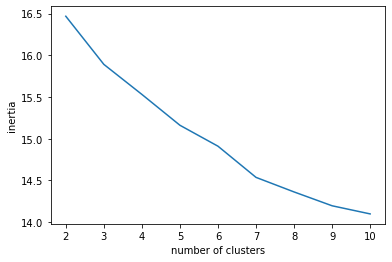

In [37]:
K_MAX_CLUSTERS = 11
inertia = []

# define the best number of clusters
for kclusters in range(2, K_MAX_CLUSTERS):
    #print(kclusters)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nycANDmosc_clustering_df)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, K_MAX_CLUSTERS), inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')

#There is an 'elbow' on the innertia graph when k = 7. Therefore the optimal number of centroids for K-mean clustering is 7

In [38]:
#Perform clustering with 7 centroids
kmeans = KMeans(n_clusters = 7, random_state = 0).fit(nycANDmosc_clustering_df)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 6, 4, 1, 4, 4, 6, 1], dtype=int32)

In [40]:
# add clustering labels
nycANDmosc_grouped_df.insert(0, 'Cluster Labels', kmeans.labels_)
# nycANDmosc_grouped_df.head(10)

,Cluster Labels,District,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,...,Tree,Used Auto Dealership,Used Bookstore,Veterinarian,Video Game Store,Video Store,Volleyball Court,Waste Facility,Weight Loss Center,Yemeni Restaurant
0,1,Aeroport,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Akademichesky,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Alexeyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,Altufyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Arbat,0.0,0.0,0.01,0.01,0.0,0.0,0.020000,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,Babushkinsky,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4,Basmanny,0.0,0.0,0.00,0.00,0.0,0.0,0.139535,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4,Begovoy,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6,Beskudnikovsky,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Bibirevo,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# now make a dafaframe with district names, cluster labels, latitudes and longitudes
moscow_merged = moscow_df

# merge manhattan_grouped with moscow_data to add latitude/longitude for each neighborhood
moscow_merged = moscow_merged.join(moscow_venues_sorted.set_index('District'), on = 'District')
moscow_merged = moscow_merged.dropna()
# add cluster label
moscow_merged['Cluster Labels'] = moscow_merged['District'].map(nycANDmosc_grouped_df.set_index('District')['Cluster Labels'])
    

moscow_merged.head(10)

,District,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Cluster Labels
0,Arbat,55.751199,37.589872,Coffee Shop,Turkish Restaurant,Bakery,Bar,Hookah Bar,Hostel,Hotel,4
1,Basmanny,55.757774,37.662184,Art Gallery,Coffee Shop,Clothing Store,Gym / Fitness Center,Nightclub,Martial Arts School,Gift Shop,4
3,Krasnoselsky,55.774248,37.659914,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Seafood Restaurant,Clothing Store,Mobile Phone Shop,Coffee Shop,1
4,Meshchansky,55.763013,37.622559,Boutique,Coffee Shop,Cocktail Bar,Hotel,Shoe Store,Clothing Store,Plaza,4
5,Presnensky,55.756276,37.605422,Park,Wine Bar,Coffee Shop,Concert Hall,Theater,Bakery,Cocktail Bar,4
6,Tagansky,55.741572,37.667063,Bar,Café,Coffee Shop,Park,Restaurant,Cosmetics Shop,Health Food Store,4
7,Tverskoy,55.762539,37.608913,Theater,Restaurant,Café,Park,Yoga Studio,Clothing Store,Health & Beauty Service,4
8,Yakimanka,55.738374,37.616913,Coffee Shop,Café,Restaurant,Gym / Fitness Center,Art Gallery,Mediterranean Restaurant,Men's Store,4
9,Zamoskvorechye,55.729095,37.641031,Coffee Shop,Café,Mobile Phone Shop,Art Gallery,Fast Food Restaurant,Sandwich Place,Bakery,4
10,Aeroport,55.800402,37.533156,Café,Coffee Shop,Cosmetics Shop,Caucasian Restaurant,Convenience Store,Flower Shop,College Quad,1


In [48]:
#same for newyork
newyork_merged = newyork_df

newyork_merged = newyork_merged.join(newyork_venues_sorted.set_index('District'), on = 'District')
newyork_merged = newyork_merged.dropna()
# add cluster label
newyork_merged['Cluster Labels'] = newyork_merged['District'].map(nycANDmosc_grouped_df.set_index('District')['Cluster Labels'])

newyork_merged.head(10)

,District,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Cluster Labels
1,Co-op City,40.874294,-73.829939,Bus Station,Fast Food Restaurant,Discount Store,Pharmacy,Grocery Store,Pizza Place,Donut Shop,0
2,Eastchester,40.887556,-73.827806,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Pizza Place,Convenience Store,Food & Drink Shop,0
4,Riverdale,40.890834,-73.912585,Bus Station,Park,Playground,Bank,Gym,Plaza,Food Truck,0
5,Kingsbridge,40.881687,-73.902818,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Bakery,Latin American Restaurant,Supermarket,5
6,Marble Hill,40.876551,-73.910660,Coffee Shop,Gym,Sandwich Place,Kids Store,Pharmacy,Bank,Donut Shop,5
7,Woodlawn,40.898273,-73.867315,Deli / Bodega,Pub,Pizza Place,Playground,Food Truck,Rental Car Location,Food & Drink Shop,2
8,Norwood,40.877224,-73.879391,Pizza Place,Park,Chinese Restaurant,Bank,Pharmacy,Mexican Restaurant,Grocery Store,3
10,Baychester,40.866858,-73.835798,Donut Shop,Fried Chicken Joint,Pizza Place,Shopping Mall,Mexican Restaurant,Mattress Store,Fast Food Restaurant,5
11,Pelham Parkway,40.857413,-73.854756,Italian Restaurant,Deli / Bodega,Frozen Yogurt Shop,Pizza Place,Chinese Restaurant,Spa,Bank,2
12,City Island,40.847247,-73.786488,Boat or Ferry,Seafood Restaurant,Thrift / Vintage Store,Deli / Bodega,Pizza Place,Spanish Restaurant,Music Venue,4


Now lets visualize our clusters on the map of Moscow!

In [58]:
# create map
def draw_clusters_map(city_latitude, city_longitude, city_merged, zoom_start):
    city_map_clusters = folium.Map(location=[city_latitude, city_longitude], zoom_start = zoom_start)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['District'], city_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(city_map_clusters)
       
    return city_map_clusters

In [59]:
#Make a map of Moscow
MOSCOW_LATITUDE = 55.751244
MOSCOW_LONGITUDE = 37.618423

draw_clusters_map(MOSCOW_LATITUDE, MOSCOW_LONGITUDE, moscow_merged, zoom_start = 10)

In [60]:
#Make a map of New York
NY_LATITUDE = 40.730610
NY_LONGITUDE = -73.935242

draw_clusters_map(NY_LATITUDE, NY_LONGITUDE, newyork_merged, zoom_start = 11)

### Analysis

As we can see, city centers of Moscow and New York are both occupied by similar (cluster 4) discticts. However, most of the periferal Moscow districts belong to cluster 1 with occasional districts belonging to clusters 6 and 3. On the other hand, New York seems to be more diverse with many districts belonging to clusters 0, 2, 3 and 5, with clusters 0 and 2 unique for New York.

Lets have a look at the cluster 4 districts, which mostly reside in city centers of Moscow and New York

In [66]:
# Moscow, cluster 4
moscow_merged.loc[moscow_merged['Cluster Labels'] == 4, moscow_merged.columns[[0] + list(range(3, moscow_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Arbat,Coffee Shop,Turkish Restaurant,Bakery,Bar,Hookah Bar,Hostel,Hotel
1,Basmanny,Art Gallery,Coffee Shop,Clothing Store,Gym / Fitness Center,Nightclub,Martial Arts School,Gift Shop
4,Meshchansky,Boutique,Coffee Shop,Cocktail Bar,Hotel,Shoe Store,Clothing Store,Plaza
5,Presnensky,Park,Wine Bar,Coffee Shop,Concert Hall,Theater,Bakery,Cocktail Bar
6,Tagansky,Bar,Café,Coffee Shop,Park,Restaurant,Cosmetics Shop,Health Food Store
7,Tverskoy,Theater,Restaurant,Café,Park,Yoga Studio,Clothing Store,Health & Beauty Service
8,Yakimanka,Coffee Shop,Café,Restaurant,Gym / Fitness Center,Art Gallery,Mediterranean Restaurant,Men's Store
9,Zamoskvorechye,Coffee Shop,Café,Mobile Phone Shop,Art Gallery,Fast Food Restaurant,Sandwich Place,Bakery
11,Begovoy,Bar,Health Food Store,Dance Studio,Tattoo Parlor,Massage Studio,Cocktail Bar,Mobile Phone Shop
20,Savyolovsky,Gym / Fitness Center,Bath House,Playground,Caucasian Restaurant,Coffee Shop,Middle Eastern Restaurant,Pet Store


In [68]:
# New York, cluster 4
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
12,City Island,Boat or Ferry,Seafood Restaurant,Thrift / Vintage Store,Deli / Bodega,Pizza Place,Spanish Restaurant,Music Venue
49,Greenpoint,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Grocery Store,French Restaurant,Yoga Studio
52,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Harbor / Marina,Yoga Studio,Pizza Place,Buffet,Café
58,Windsor Terrace,Diner,Plaza,Park,Grocery Store,Italian Restaurant,Arts & Crafts Store,Chinese Restaurant
59,Prospect Heights,Bar,Mexican Restaurant,Thai Restaurant,Restaurant,Wine Shop,Cocktail Bar,Coffee Shop
...,...,...,...,...,...,...,...,...
280,Vinegar Hill,Food Truck,Coffee Shop,Café,Bar,Art Gallery,Park,Scenic Lookout
281,Weeksville,Gas Station,Laundry Service,Discount Store,Donut Shop,Coffee Shop,Cocktail Bar,Chinese Restaurant
283,Dumbo,Park,Scenic Lookout,Ice Cream Shop,Bakery,Coffee Shop,American Restaurant,Italian Restaurant
301,Hudson Yards,Gym / Fitness Center,Hotel,American Restaurant,Italian Restaurant,Café,Coffee Shop,Boat or Ferry


Now, lets have a look at the сluster 1, which covers most of the periferal clusters of Moscow

In [70]:
# Moscow, cluster 1
moscow_merged.loc[moscow_merged['Cluster Labels'] == 1, moscow_merged.columns[[0] + list(range(3, moscow_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
3,Krasnoselsky,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Seafood Restaurant,Clothing Store,Mobile Phone Shop,Coffee Shop
10,Aeroport,Café,Coffee Shop,Cosmetics Shop,Caucasian Restaurant,Convenience Store,Flower Shop,College Quad
15,Khoroshyovsky,Clothing Store,Supermarket,Coffee Shop,Gastropub,Noodle House,Salon / Barbershop,Blini House
18,Levoberezhny,Sushi Restaurant,Auto Workshop,Brewery,Bus Stop,Middle Eastern Restaurant,Food & Drink Shop,Skate Park
25,Zapadnoye Degunino,Cosmetics Shop,Eastern European Restaurant,Pool,Electronics Store,Dance Studio,Paper / Office Supplies Store,Health Food Store
26,Alexeyevsky,Auto Workshop,Hotel,Supermarket,Health Food Store,Bus Stop,Café,Snack Place
28,Babushkinsky,Notary,Fast Food Restaurant,Pet Store,Mobile Phone Shop,Paper / Office Supplies Store,Gym,Clothing Store
29,Bibirevo,Fast Food Restaurant,Clothing Store,Cosmetics Shop,Shipping Store,Big Box Store,Furniture / Home Store,Middle Eastern Restaurant
30,Butyrsky,Music Venue,Convenience Store,Theater,Flower Shop,Park,Pedestrian Plaza,Coffee Shop
34,Maryina roshcha,Fast Food Restaurant,Electronics Store,Toy / Game Store,Jewelry Store,Farmers Market,Clothing Store,Adult Boutique


Finally, lets check clusters 0 and 2, which are unique for New York 

In [71]:
# New York, cluster 0
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,Co-op City,Bus Station,Fast Food Restaurant,Discount Store,Pharmacy,Grocery Store,Pizza Place,Donut Shop
2,Eastchester,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Pizza Place,Convenience Store,Food & Drink Shop
4,Riverdale,Bus Station,Park,Playground,Bank,Gym,Plaza,Food Truck
18,West Farms,Bus Station,Donut Shop,Park,Bus Line,Gym,Coffee Shop,Basketball Court
25,Morrisania,Grocery Store,Fast Food Restaurant,Bus Station,Discount Store,Donut Shop,Pizza Place,Bowling Alley
26,Soundview,Chinese Restaurant,Burger Joint,Bus Stop,Liquor Store,Basketball Court,Latin American Restaurant,Video Store
41,Olinville,Caribbean Restaurant,Food,Fried Chicken Joint,Metro Station,Liquor Store,Convenience Store,Basketball Court
42,Pelham Gardens,Pharmacy,Bus Station,Baseball Field,Boat or Ferry,Grocery Store,Food,Pizza Place
43,Concourse,Bus Station,Grocery Store,Metro Station,Deli / Bodega,Spanish Restaurant,Bakery,Pharmacy
56,East Flatbush,Chinese Restaurant,Print Shop,Fast Food Restaurant,Moving Target,Liquor Store,Caribbean Restaurant,Park


In [72]:
# New York, cluster 2
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
7,Woodlawn,Deli / Bodega,Pub,Pizza Place,Playground,Food Truck,Rental Car Location,Food & Drink Shop
11,Pelham Parkway,Italian Restaurant,Deli / Bodega,Frozen Yogurt Shop,Pizza Place,Chinese Restaurant,Spa,Bank
13,Bedford Park,Deli / Bodega,Pizza Place,Diner,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Grocery Store
28,Throgs Neck,Deli / Bodega,Coffee Shop,Italian Restaurant,Asian Restaurant,Sports Bar,Liquor Store,Pizza Place
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Bank,Dessert Shop
39,Edgewater Park,Italian Restaurant,Deli / Bodega,Pizza Place,Donut Shop,Beach,Pub,Park
54,Flatbush,Deli / Bodega,Caribbean Restaurant,Coffee Shop,Bank,Fast Food Restaurant,Pizza Place,Donut Shop
89,Ocean Hill,Deli / Bodega,Grocery Store,Fried Chicken Joint,Supermarket,Bakery,Southern / Soul Food Restaurant,Chinese Restaurant
146,Woodhaven,Deli / Bodega,Park,Bank,Pharmacy,Restaurant,Bar,Fried Chicken Joint
148,South Ozone Park,Deli / Bodega,Park,Bar,Sandwich Place,Donut Shop,Food Truck,Fast Food Restaurant
